In [3]:
# force geopandas to use shapely instead of pygeos
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import plotly.express as px
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [4]:
df = pd.read_csv("../data/data_2022_with_geom.csv")
df.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom
0,950226616,2022-04-20 12:10:00,TRC7.2.22,STR CLEAN,1318 FILBERT ST,CA,V507699,84.0,05/01/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
1,952126114,2022-06-17 16:12:00,TRC7.2.20,RES/OT,1318 FILBERT ST,CA,BV44D97,96.0,07/17/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
2,950441903,2022-04-23 15:13:00,V5200,NO PLATES,1318 FILBERT ST,CA,V507699,121.0,05/18/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
3,948460144,2022-02-22 11:54:00,TRC7.2.20,RES/OT,1318 FILBERT ST,TX,HVT6737,96.0,05/23/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
4,948169644,2022-02-17 13:39:00,TRC7.2.20,RES/OT,1318 FILBERT ST,OH,HQA6554,96.0,04/03/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)


In [5]:
# convert to geodf for spatial join

df['geom'] = df.geom.apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geom')
df.crs = 'EPSG:4326'

In [6]:
# convert date column from string to datetime.

df['Citation Issued DateTime'] = pd.to_datetime(df['Citation Issued DateTime'])

In [16]:
def clean_address(string):
    address_words = string.split(' ')
    if address_words[0].isnumeric():
        return ' '.join(address_words[1:])
    return string

df = df[~df['Citation Location'].isnull()]
df['street'] = df['Citation Location'].apply(clean_address)

In [33]:
uniqueaddresses = df['Citation Location'].apply(clean_address).unique().tolist()
len(uniqueaddresses)

3360

In [41]:
if 'TERRY A FRANCOIS BOULEVARD' in uniqueaddresses:
    print("Yes")
else:
    print("No")

Yes


In [8]:
def JaccardDist(str1, str2):
    str1 = set(str1.split())
    str2 = set(str2.split())
    return float(len(str1 & str2)) / len(str1 | str2)

In [31]:
JaccardDist(uniqueaddresses[0],uniqueaddresses[1])


0.3333333333333333

In [42]:
JaccardDist('TERRY A FRANCOIS BOULEVARD', 'TERRY A FRANCOIS BLVD')

0.6

In [47]:
JaccardDist(uniqueaddresses[0],uniqueaddresses[1])
jaccard_list = []
i_index = []
j_index = []
for i in range(0,len(uniqueaddresses) - 1):
    for j in range(i+1,len(uniqueaddresses)):
        jaccard_list.append(JaccardDist(uniqueaddresses[i],uniqueaddresses[j]))
        i_index.append(i)
        j_index.append(j)



In [48]:
dfjaccard = pd.DataFrame(list(zip(i_index, j_index, jaccard_list)),
                         columns =['i', 'j', 'jaccard'])


In [49]:
len(dfjaccard)

5643120

In [50]:
dfjaccard.head(-10)

,i,j,jaccard
0,0,1,0.333333
1,0,2,0.000000
2,0,3,0.333333
3,0,4,0.333333
4,0,5,0.000000
...,...,...,...
5643105,3354,3355,0.333333
5643106,3354,3356,0.250000
5643107,3354,3357,0.333333
5643108,3354,3358,0.000000


In [52]:
similar_addresses_df = dfjaccard[dfjaccard['jaccard'] > 0.5]
similar_addresses_df.head()


,i,j,jaccard
11137,3,1067,0.666667
41535,12,1306,0.666667
50652,15,388,0.666667
130615,39,395,0.666667
134089,40,550,0.600000


In [67]:
similar_addresses_df['i_name'] = similar_addresses_df.i.map(pd.Series(uniqueaddresses))
similar_addresses_df['j_name'] = similar_addresses_df.j.map(pd.Series(uniqueaddresses))
similar_addresses_df.head()

C:\Users\SKPC\AppData\Local\Temp\ipykernel_10644\1105567953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_addresses_df['i_name'] = similar_addresses_df.i.map(pd.Series(uniqueaddresses))
C:\Users\SKPC\AppData\Local\Temp\ipykernel_10644\1105567953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_addresses_df['j_name'] = similar_addresses_df.j.map(pd.Series(uniqueaddresses))


,i,j,jaccard,i_name,j_name
11137,3,1067,0.666667,CLAY ST,WEST CLAY ST
41535,12,1306,0.666667,WEST PORTAL STATION,WEST PORTAL
50652,15,388,0.666667,MISSION ST,MISSION ROCK ST
130615,39,395,0.666667,MONTGOMERY ST,NEW MONTGOMERY ST
134089,40,550,0.600000,TERRY A FRANCOIS BLVD,TERRY A FRANCOIS BOULEVARD


In [69]:
print(similar_addresses_df.to_markdown())

|         |    i |    j |   jaccard | i_name                         | j_name                             |
|--------:|-----:|-----:|----------:|:-------------------------------|:-----------------------------------|
|   11137 |    3 | 1067 |  0.666667 | CLAY ST                        | WEST CLAY ST                       |
|   41535 |   12 | 1306 |  0.666667 | WEST PORTAL STATION            | WEST PORTAL                        |
|   50652 |   15 |  388 |  0.666667 | MISSION ST                     | MISSION ROCK ST                    |
|  130615 |   39 |  395 |  0.666667 | MONTGOMERY ST                  | NEW MONTGOMERY ST                  |
|  134089 |   40 |  550 |  0.6      | TERRY A FRANCOIS BLVD          | TERRY A FRANCOIS BOULEVARD         |
|  136422 |   40 | 2883 |  0.75     | TERRY A FRANCOIS BLVD          | TERRY A FRANCOIS                   |
|  136866 |   40 | 3327 |  0.75     | TERRY A FRANCOIS BLVD          | TERRY FRANCOIS BLVD                |
|  156138 |   46 | 2706 |  0

In [75]:
df['Citation Location'] = df['Citation Location'].str.replace('BOULEVARD', 'BLVD')
num_citations_by_location = df['Citation Location'].value_counts()
gb_first = df.groupby('Citation Location').nth(0)

citation_df = gpd.GeoDataFrame(pd.merge(num_citations_by_location, gb_first, left_index=True, right_on='Citation Location'), geometry='geom')
citation_df.rename({'Citation Location': 'citation_count'}, axis=1, inplace=True)
citation_df.head(n=30)['citation_count']

Citation Location
501 TERRY A FRANCOIS BLVD    1830
993 POTRERO AVE               589
200 CHANNEL ST                575
492 CASTRO ST                 519
100 SPEAR ST                  444
300 FREMONT ST                420
3252 PIERCE ST                380
EMBARCADERO STATION           343
500 HOWARD ST                 331
POWELL STATION                329
1001 POTRERO AVE              309
1325 08TH AVE                 300
500 BRANNAN ST                299
500 20TH ST                   279
600 HARRISON ST               278
0 01ST ST                     276
200 SPEAR ST                  273
299 FREMONT ST                270
300 BRANNAN ST                264
11 SPEAR ST                   257
400 BRANNAN ST                255
680 MISSION ST                254
100 YACHT ROAD                251
203 FOLSOM ST                 247
2395 LOMBARD ST               239
2450 CALIFORNIA ST            233
1550 MISSION ST               227
545 FOLSOM ST                 224
300 HOWARD ST                 

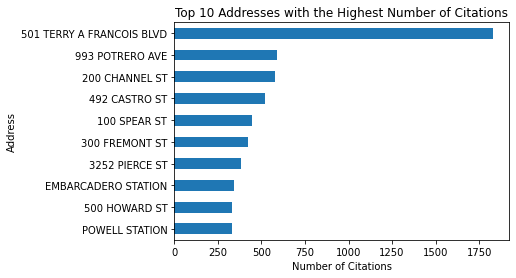

In [76]:
citation_df.head(n=10).iloc[::-1]['citation_count'].plot(kind='barh')
plt.ylabel("Address")
plt.xlabel("Number of Citations")
plt.title("Top 10 Addresses with the Highest Number of Citations");

In [51]:
dfjaccard['jaccard'].max()

1.0

[Text(0.5, 0, 'Hours'), Text(0, 0.5, 'Number of Citations'), (0.0, 168.0)]

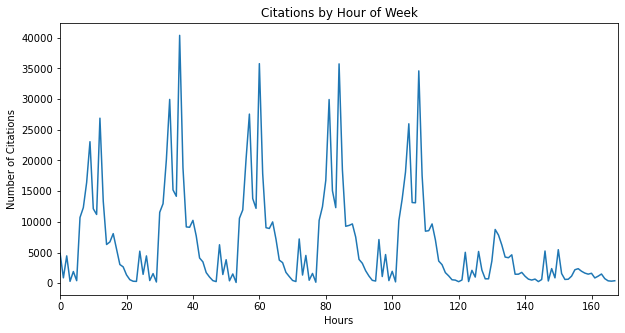

In [27]:
ax1 = df.groupby((df['Citation Issued DateTime'].dt.dayofweek) * 24 + (df['Citation Issued DateTime'].dt.hour)).size().plot(kind='line', 
title='Citations by Hour of Week', figsize=(10,5))
ax1.set(xlabel='Hours', ylabel='Number of Citations',xlim=(0,168))
#ax1.xaxis.set(
    #major_locator=mdates.DayLocator(),
    #major_formatter=mdates.DateFormatter("\n\n%A"),
    #minor_locator=mdates.HourLocator((0, 12)),
    #minor_formatter=mdates.DateFormatter("%H"),
#)

In [ ]:
fig, ax2 = plt.subplots(figsize=(10,5))
ax2.set(xlabel='', ylabel='Total Number of Citations')
ax2.plot(df['Citation Issued DateTime'], df)
